# 1. Importing Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt         

Loading the files

In [2]:
# Load the CSV file
csv_file_path = '/Users/gregorycrooks/Downloads/pitch_by_pitch_metadata 2.csv'
csv_data = pd.read_csv(csv_file_path, encoding='latin-1')

# Display the first few rows of the CSV to understand its structure
print(csv_data.head())

# Load the text file
text_file_path = '/Users/gregorycrooks/Downloads/pitches_folder/pitches'
with open(text_file_path, 'r') as file:
    text_data = file.readlines()

  column_name available_prior_to_pitch                   description
0         uid                      Yes                     unique id
1     game_pk                      Yes                unique game id
2        year                      Yes                          year
3        date                      Yes                          date
4   team_id_b                      Yes  team_id for the batting team


### Cleaning up the Data

In [230]:
import os
import pickle
import random
import pandas as pd

# Define the pickle file path
pickle_file = '/Users/gregorycrooks/Downloads/pitches_folder/pitches.pkl'

# Check if the pickle file exists
if os.path.exists(pickle_file):
    # If the file exists, load the DataFrame from the pickle file
    with open(pickle_file, 'rb') as f:
        df = pickle.load(f)
    print("Data loaded from pickle file.")
else:
    # If the file doesn't exist, run the code to process the data and save it as a pickle file
    
    # Assuming text_data contains both the header and the values
    # The first row is the header, and the rest are the data
    header = text_data[0]
    data = text_data[1:]  # Exclude the header

    # Randomly sample rows from the data
    random_sample = random.sample(data, 500000)

    # Split the header by commas and remove double quotes
    header = [col.replace('"', '') for col in header.split(",")]

    # Create an empty list to hold valid rows
    valid_rows = []

    # Loop through each sampled row
    for i in random_sample:
        # Split each row by commas and remove double quotes from each value
        row = [val.replace('"', '') for val in i.split(",")]

        # Check for different row lengths
        if len(row) == 126:
            # If the length is 126, find and pop one value
            consecutive_empty_count = 0
            for index in range(len(row)):
                if row[index] == "":
                    consecutive_empty_count += 1
                    if consecutive_empty_count == 2:
                        # Pop one empty value
                        row.pop(index)
                        break  # Break after removing one value
                else:
                    consecutive_empty_count = 0  # Reset if a non-empty value is found

        elif len(row) == 127:
            # If the length is 127, find and pop two values
            consecutive_empty_count = 0
            for index in range(len(row)):
                if row[index] == "":
                    consecutive_empty_count += 1
                    if consecutive_empty_count == 2:
                        # Pop two consecutive values
                        del row[index-1:index+1]  # Remove two consecutive values starting from index-1
                        break  # Break after removing two values
                else:
                    consecutive_empty_count = 0  # Reset if a non-empty value is found

        # If the length is 125, do nothing (just append the row)
        if len(row) == 125:
            valid_rows.append(row)

    # Create a DataFrame using the valid rows and adjust the header if needed
    df = pd.DataFrame(valid_rows, columns=header[:len(valid_rows[0])])

    # Save the DataFrame to a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(df, f)
    print("Data processed and saved to pickle file.")

df = df[:400000]

Data loaded from pickle file.


# 2. EDA

### Initial Data Exploration

In [4]:
df.columns

Index(['uid', 'game_pk', 'year', 'date', 'team_id_b', 'team_id_p', 'inning',
       'top', 'at_bat_num', 'pcount_at_bat',
       ...
       'runner7_start', 'runner7_end', 'runner7_event', 'runner7_score',
       'runner7_rbi', 'runner7_earned', 'created_at', 'added_at',
       'modified_at', 'modified_by\n'],
      dtype='object', length=125)

Dropping irrelevant columns

In [231]:
df = df.drop(df.columns[72:125], axis=1)


In [6]:
df.tail(5)

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b
49995,19379979,289148,2011,2011-09-16,146,120,9,1,66,1,...,FT,0.903,12,56,219.431,2202.602,,466988,,
49996,14476050,287044,2011,2011-04-12,108,114,8,0,59,4,...,SL,0.915,4,37,61.538,660.565,,110029,,488721
49997,16089295,287745,2011,2011-06-01,139,140,3,0,21,7,...,FF,0.874,4,40,194.923,2225.909,Colby Lewis is still attacking Ben Zobrist wit...,,,
49998,14753046,287167,2011,2011-04-21,113,109,4,0,35,2,...,SL,2.000,3,44,249.521,474.096,,,,
49999,14793887,287185,2011,2011-04-22,158,117,6,0,55,1,...,FT,0.903,12,66,219.848,2312.467,,,,


Duplicated rows: we find none

In [7]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b


Identifying column types:

In [8]:
df.dtypes.value_counts()

object    72
dtype: int64

Cleaning Empty Strings:

In [232]:
# Replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)


Removing additional columns:

In [233]:
df = df.drop(columns=['date','pitch_tfs', 'start_tfs', 'start_tfs_zulu'])

### Outlier Detection

Detecting outliers for start_speed - We find an abnormally high valueq which distort the mean

110720125751.0


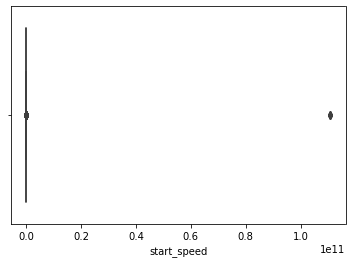

In [11]:
sns.boxplot(x=df['start_speed'].astype(float))
print(df['start_speed'].astype(float).max())

Detecting outlier for end speed - we find the same issue as start_speed

110603200849.0


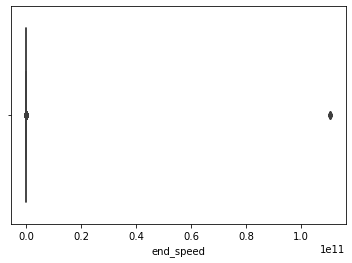

In [12]:
sns.boxplot(x=df['end_speed'].astype(float))
print(df['end_speed'].astype(float).max())

Detecting outliers for batter_height - no disproportionately high or low value

<AxesSubplot:xlabel='b_height'>

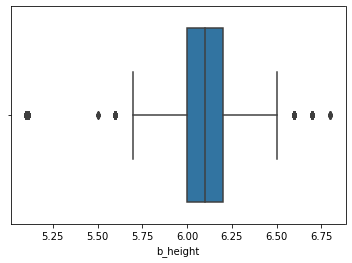

In [13]:
df['b_height'] = df['b_height'].replace('-', '.', regex=True)

sns.boxplot(x=df['b_height'].astype(float))

### Column Types

Column types

In [14]:
df.dtypes

uid          object
game_pk      object
year         object
team_id_b    object
team_id_p    object
              ...  
spin_rate    object
cc           object
on_1b        object
on_2b        object
on_3b        object
Length: 68, dtype: object

Converting columns to relevant type 

In [234]:
# List of categorical columns
df_cat = ['uid', 'game_pk', 'team_id_b', 'team_id_p', 'pitcher_id', 
          'batter_id', 'event', 'event2', 'event3', 'event4', 'pitch_type', 'zone', 'pitch_id', 'pitch_des', 'is_final_pitch',
          'on_1b', 'on_2b', 'on_3b', 'type', 'at_bat_des','sv_id']
# Convert categorical columns to object type
df[df_cat] = df[df_cat].astype('object')

# Apply numeric conversion to all other columns except the categorical columns
for column in df.columns:
    if column not in df_cat:
        df[column] = pd.to_numeric(df[column], errors='coerce')


Let's look at the numerical columns added:

In [16]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics).head()

,year,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,...,az,ay,break_length,break_y,break_angle,type_confidence,nasty,spin_dir,spin_rate,cc
0,2011,2,0,13,3,19,1,1,0,0,...,-31.438,19.241,9.5,23.9,-6.2,2.000,50.0,103.373,403.661,NaN
1,2011,3,0,25,3,62,0,2,1,1,...,-31.185,22.902,8.8,23.8,-4.2,0.849,37.0,122.625,221.826,NaN
2,2011,8,1,67,1,19,0,0,0,1,...,-13.982,30.378,3.6,23.8,-5.4,2.000,49.0,179.205,1995.267,NaN
3,2011,3,1,17,2,35,0,1,0,1,...,-37.022,22.817,10.3,23.9,-9.4,2.000,64.0,48.537,874.509,NaN
4,2011,7,1,51,3,116,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Year is only 2011. It might've been interesting to do a Drift Analysis if there were other years, which is not the case

In [235]:
df = df.drop(columns=['year'])

cc has a very high count of nulls; let's remove that columns

In [236]:
print(df.cc.isna().sum())
df = df.drop(columns=['cc'])

399926


This leaves us with 45 numerical columns and 21 categorical columns:

In [19]:
num_columns = df.select_dtypes(include=numerics).count()
cat_columns = df.select_dtypes(include=object).count()

print(len(num_columns), len(cat_columns))

45 21


Interquartile range

In [20]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR.head()

inning             4.0
top                1.0
at_bat_num        39.0
pcount_at_bat      3.0
pcount_pitcher    51.0
dtype: float64

### Removing Outliers

Removing outliers to avoid skewed results, and bias during model implementation

/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_25246/2909743454.py:1: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



<AxesSubplot:xlabel='start_speed'>

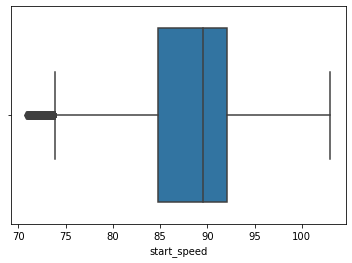

In [237]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
sns.boxplot(x=df['start_speed'].astype(float))


### Pitch Types

Pitch Types:

In [22]:
df['pitch_type'].value_counts()

FF    5741
SI    2179
FT    2115
SL    2065
CH    1935
FC     996
CU     734
FS     253
KC     162
KN      54
FO       8
FA       5
PO       2
IN       1
Name: pitch_type, dtype: int64

Removing bad pitch type - in some instances, pitches have numerical values; we remove them

In [238]:
df = df[~df['pitch_type'].apply(lambda x: isinstance(x, (int, float)))]
df = df[pd.to_numeric(df['pitch_type'], errors='coerce').isna()]
df = df.reset_index(drop=True)

Renaming the pitch types - We find imbalances in the pitch type counts, which will need to be dealt further during in the pre-processing steps. To pre-emptively reduce imbalance, we can combine similar pitch types together (ex: 'Two-seam Fastball' and 'Two Seam Fastball' as 'Fastball').

In [239]:
# Dictionary mapping pitch types, combining Fastballs and Curveballs
pitch_type_combined_mapping = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FC': 'Cutter',
    'EP': 'Eephus',
    'FO': 'Forkball',
    'FT': 'Fastball',  # Combine Two-Seam Fastball
    'FA': 'Fastball',  # Combine Two-Seam Fastball
    'FF': 'Fastball',  # Combine Four-Seam Fastball
    'KN': 'Knuckleball',
    'KC': 'Curveball',  # Combine Knuckle-Curve into Curveball
    'PO': 'Pitcher Only',
    'SC': 'Screwball',
    'SI': 'Sinker',
    'SL': 'Slider',
    'SV': 'Slurve',
    'FS': 'Splitter',
    'ST': 'Sweeper'
}

# Replace the pitch types in the 'pitch_type' column with combined categories
df['pitch_type'] = df['pitch_type'].replace(pitch_type_combined_mapping)


Removing the ones with little to no observations 

In [240]:
df = df[~df['pitch_type'].isin(["Forkball", "IN", "Pitcher Only", "Screwball", "Eephus", "UN", "AB"])]
df['pitch_type'].value_counts()


Fastball       79786
Sinker         21922
Slider         20758
Changeup       18620
Cutter         10066
Curveball       8778
Splitter        2266
Knuckleball      577
Name: pitch_type, dtype: int64

### Final Pitches

Is final pitch a parameter to determine the pitch type? - We find that 24% of the pitches are final pitches; we can check if certain pitch types are thrown more frequently in the final pitch

In [26]:
# In all t
df.is_final_pitch.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'


0    76.2%
1    23.8%
Name: is_final_pitch, dtype: object

There is little difference between the proportion of final pitches in the data, and the proportion of final pitch by each unique pitch type

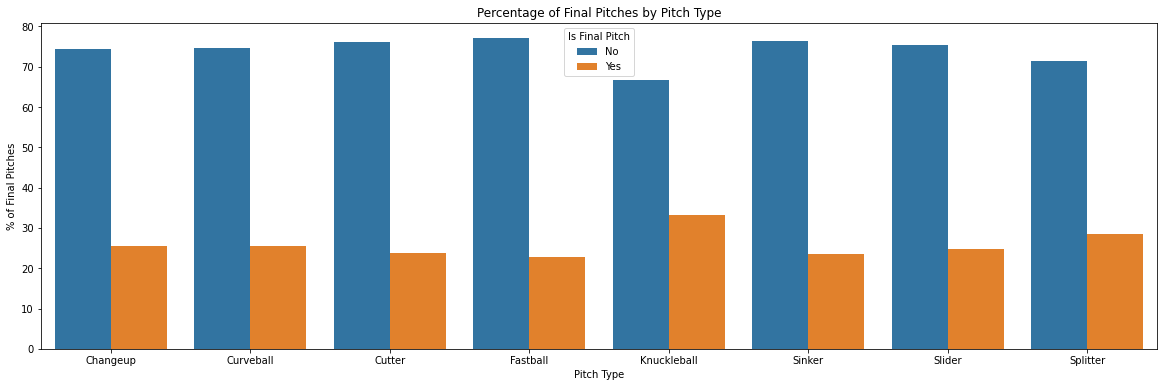

In [27]:
df.is_final_pitch = df.is_final_pitch.replace({'0': "No", '1': "Yes"})
# Group by 'pitch_type' and 'is_final_pitch', and count the occurrences
grouped_data = df.groupby(['pitch_type', 'is_final_pitch']).size().reset_index(name='pitch_count')

# Calculate the total count for each 'pitch_type'
grouped_data['total_count'] = grouped_data.groupby('pitch_type')['pitch_count'].transform('sum')

# Calculate the percentage for each group within the 'pitch_type'
grouped_data['percentage'] = (grouped_data['pitch_count'] / grouped_data['total_count']) * 100

# Create a Seaborn plot
plt.figure(figsize=(20, 6))  # Set the figure size
sns.barplot(x='pitch_type', y='percentage', hue='is_final_pitch', data=grouped_data)

plt.title('Percentage of Final Pitches by Pitch Type')
plt.ylabel('% of Final Pitches')
plt.xlabel('Pitch Type')
plt.legend(title='Is Final Pitch')
plt.show()


### Start Speed

Histogram start_speed - Left Skewness and Unimodal Distribution

<AxesSubplot:xlabel='start_speed', ylabel='Count'>

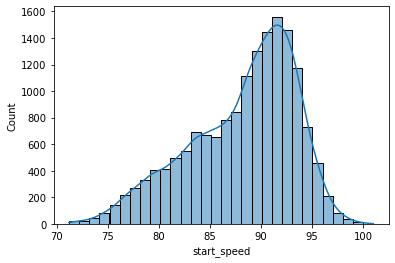

In [70]:
sns.histplot(data=df, x="start_speed", bins=30, kde=True)

Histograms for Fastball pitch type - the distribution tends to be more normal than the entire data's. The histogram shows a mild left skewness.

<AxesSubplot:xlabel='start_speed', ylabel='Count'>

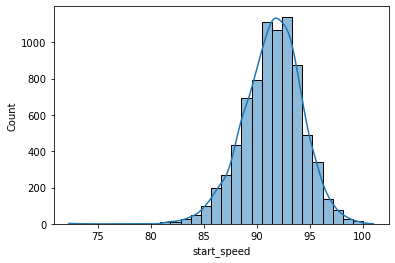

In [71]:
sns.histplot(data=df[df["pitch_type"] == "Fastball"], x="start_speed", bins=30, kde=True)

Let's look at the start speed description across data

In [30]:
df.start_speed.describe()

count    16239.000000
mean        88.189063
std          5.197638
min         71.200000
25%         84.700000
50%         89.300000
75%         92.100000
max        101.000000
Name: start_speed, dtype: float64

Comparing the start speed numerical descriptions with certain pitch types - Fastball start speed mean and median are higher than the data's, and more clustered around the mean

In [31]:
df[df["pitch_type"] == "Fastball"].start_speed.describe()

count    7861.000000
mean       91.488729
std         2.782257
min        72.300000
25%        89.800000
50%        91.700000
75%        93.300000
max       101.000000
Name: start_speed, dtype: float64

The curveball pitch types have an average start speed 10 mph slower than the data mean. They are also more clustered around the mean

In [32]:
df[df["pitch_type"] == "Curveball"].start_speed.describe()

count    896.000000
mean      78.161942
std        2.656488
min       71.300000
25%       76.500000
50%       78.100000
75%       79.700000
max       88.600000
Name: start_speed, dtype: float64

Let's create boxplots for each pitch type, and one for the entire data - overall, the speed type might potentially be good in determining the type of pitch. We see that the start speed strongly varies according to the pitch type. For instance, median start speed for Changeupd will be significantly slower than for Fastballs

In [33]:
import plotly.graph_objects as go
# get median start_speed 
median_speed = df.groupby('pitch_type')['start_speed'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['start_speed'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['start_speed'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of start speed by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "Start Speed",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

Multimodality - Are there differences on whether it is the final pitch or not? - We find little modality with regards to the final pitch

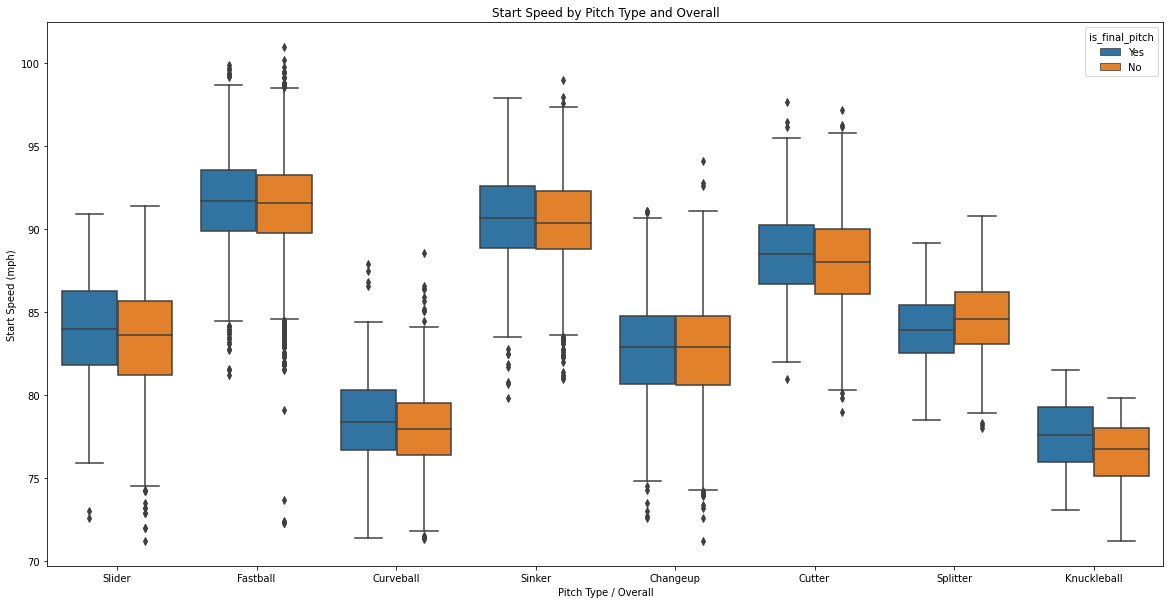

Count of Forkball is 0


In [34]:
plt.figure(figsize=(20, 10))
# Create a grouped boxplot comparing start_speed across different pitch types
sns.boxplot(x='pitch_type', y='start_speed', hue= df.is_final_pitch,data=df)
# Overlay a separate boxplot for the overall data
# Add titles and labels
plt.title('Start Speed by Pitch Type and Overall')
plt.xlabel('Pitch Type / Overall')
plt.ylabel('Start Speed (mph)')

plt.show()
print("Count of Forkball is", df[df['pitch_type'] == "Forkball"].count().max())

### Batter Height

Batter Height and Pitch Type -  Batter's most frequent height is 6.2 feet

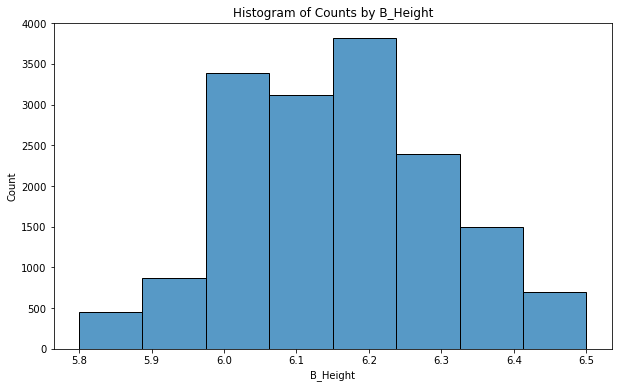

In [35]:
counts = df.groupby('b_height').size()
unique_b_height = df.b_height.nunique()

# Step 2: Plot histogram based on the counts
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="b_height", bins=unique_b_height)
# Add labels and title
plt.title('Histogram of Counts by B_Height')
plt.xlabel('B_Height')
plt.ylabel('Count')

# Show the plot
plt.show()

Batter Height for each pitch type - The most frequent batter height count is 6.2 feet across almost all pitch types. This indicates that height might not be a strong feature for pitch type differentiation

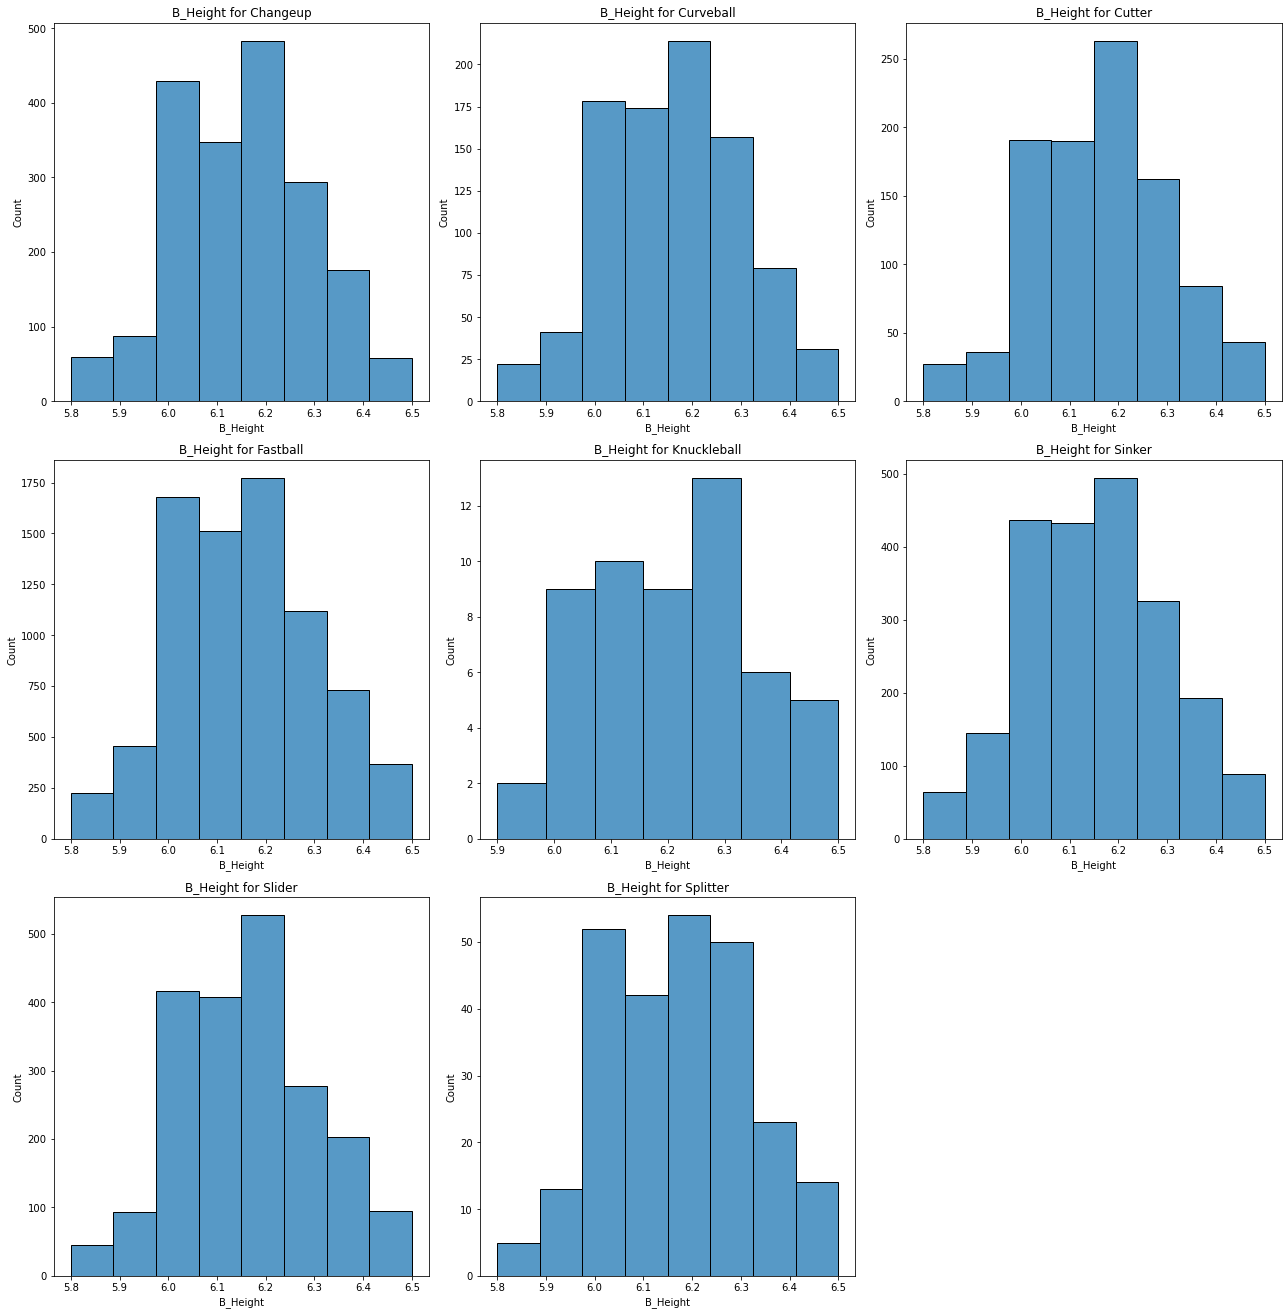

In [36]:

# Group by 'pitch_type'
grouped = df.groupby('pitch_type')

# Create a figure with 3 columns and 4 rows to accommodate 10 pitch types
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 24))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Loop through each pitch type and corresponding axis to plot histograms
for (pitch_type, group), ax in zip(grouped, axes):
    # Count the unique heights for binning purposes
    unique_b_height = group['b_height'].nunique()
    
    # Plot histogram for each pitch type
    sns.histplot(data=group, x='b_height', bins=unique_b_height, ax=ax)
    
    # Add labels and title for each subplot
    ax.set_title(f'B_Height for {pitch_type}')
    ax.set_xlabel('B_Height')
    ax.set_ylabel('Count')

# Remove any empty subplots
for i in range(len(grouped), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


### Inning

Are certain pitch types more likely to occur in the bottom half or top half inning

In [37]:
df.top = df.top.replace({0: "No", 1: "Yes"})
df.top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Yes    51.5%
No     48.5%
Name: top, dtype: object

Are some pitch types more frequent in the top of bottom half of inning, when comparing to the overall data ? Mild difference with fastballs more frequent in top inning

In [38]:
df[df["pitch_type"] == "Sinker"].top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

No     50.8%
Yes    49.2%
Name: top, dtype: object

In [39]:
df[df["pitch_type"] == "Fastball"].top.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Yes    52.4%
No     47.6%
Name: top, dtype: object

What about the end speed comparison between pitch_types? - The mean end speed is 81mph, with a range of values between 65 to 94mph

In [40]:
df.end_speed.describe()

count    16239.000000
mean        81.358489
std          4.745773
min         65.900000
25%         78.200000
50%         82.400000
75%         84.900000
max         93.300000
Name: end_speed, dtype: float64

### End Speed

End speed strongly varies according to pitch types, with the median speed as a good indicator to determine the type. Although the patterns of the boxplots are strongly similar with start_speed.

In [41]:
# get median end_speed 
median_speed = df.groupby('pitch_type')['end_speed'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['end_speed'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['end_speed'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of end speed by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "End Speed",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

### Speed collinearity

Let's see if these two variables are correlated - we find an extremely strong positive correlation which highlights collinearity. This means that we can remove one of these two variables without losing much interpretability

In [42]:
df_speed = df.loc[:,["end_speed", 'start_speed']]
df_speed.corr()

,end_speed,start_speed
end_speed,1.000000,0.996952
start_speed,0.996952,1.000000


Is speed highly correlated with other variables? - vy0 shows an extremely high correlation to both speeds. This also indicates collinearity

High Correlations with start_speed:
start_speed     1.000000
end_speed       0.996952
pfx_z           0.614117
vy0            -0.999766
az              0.679970
ay              0.873457
break_length   -0.796564
Name: start_speed, dtype: float64


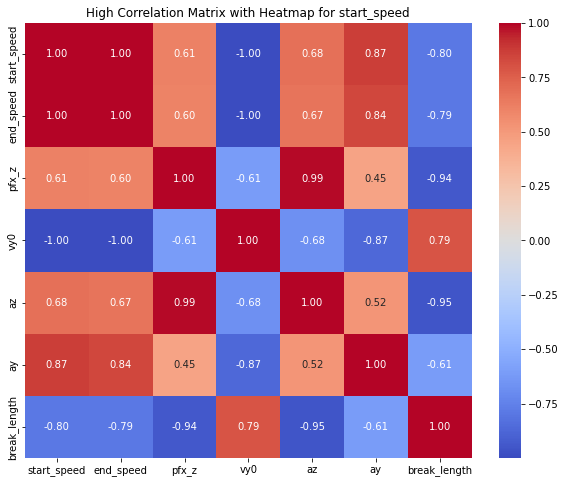

In [43]:
# Sample data loading (assuming 'df' is already loaded)
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select correlations related to 'sz_bot' and filter for high correlations
high_correlations = correlation_matrix['start_speed'][correlation_matrix['start_speed'].abs() > 0.6]

# Print the high correlation values
print("High Correlations with start_speed:")
print(high_correlations)

# Create a new DataFrame for the heatmap that only includes features with high correlations
high_corr_features = high_correlations.index.tolist()
high_corr_matrix = df[high_corr_features].corr()

# Visualization using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('High Correlation Matrix with Heatmap for start_speed')
plt.show()

### Pitch Break

Break columns by pitch type:

In [44]:
df_break_pitch_type = df.loc[:, ["break_length","break_angle", "pitch_type"]]
df_break_pitch_type

,break_length,break_angle,pitch_type
0,8.8,-4.2,Slider
1,3.6,-5.4,Fastball
2,4.0,-1.2,Fastball
3,12.5,-10.6,Curveball
4,8.2,-3.2,Slider
...,...,...,...
16245,4.0,34.2,Fastball
16246,7.8,8.2,Slider
16247,9.3,8.0,Splitter
16248,9.5,-9.1,Slider


Fastballs will be faster with little curvature; shorter break length than other pitch types. A higher curve will indicate a longer break length. This helps indicate the different types of pitches

In [45]:
df_break_pitch_type.groupby(["pitch_type"]).mean()

,break_length,break_angle
pitch_type,,
Changeup,7.861757,3.245116
Curveball,12.263170,-7.112388
Cutter,5.647490,-4.348795
Fastball,4.695268,7.538265
Knuckleball,10.359259,-0.383333
Sinker,6.389582,14.982698
Slider,8.548329,-6.070218
Splitter,7.578656,14.173518


We find little to no relationship between break angle and the break length

In [46]:
df_break_pitch_type.corr()

,break_length,break_angle
break_length,1.000000,-0.171705
break_angle,-0.171705,1.000000


Comparing break angle: we find more variability in relation to the overall data with the: Knuckelball, Cutter, Slider, Curveball, Knuckle-Curve. The median of the first 5 derive less from the overall data median. This shows that the Break Angle strongly varies according to the pitch

In [47]:
# get median end_speed 
median_speed = df.groupby('pitch_type')['break_angle'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['break_angle'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['break_angle'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of Break Angle by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "Break Angle",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

For break length, we find a higher variability across pitch types in relation to the dataset. This shows to be an even better feature than the Break Angle, since most pitch types vary from each other as well as the overall data.

In [48]:
# get median end_speed 
median_speed = df.groupby('pitch_type')['break_length'].median()

sorted_pitch_types = median_speed.sort_values(ascending = False).index

box_plots = []

# ADD BOXPLOT FOR ALL DATA
box_plots.append(
  go.Box(
    y = df['break_length'],
    name = 'All Data',
    boxpoints = 'outliers',
    marker = dict(color = 'grey'),
    opacity = 0.5
  )
)
    
for pitch_type in sorted_pitch_types:
  box_plots.append(
    go.Box(
      y = df[df['pitch_type'] == pitch_type]['break_length'],
      name = pitch_type,
      boxpoints = 'outliers',
      #jitter = 0.3,
      #pointpos = -1.8
    )
)
 
fig = go.Figure(data = box_plots)

fig.update_layout(
  title = "Box plots of Break Length by pitch type",
  xaxis_title = "Pitch Type",
  yaxis_title = "Break Length",
  xaxis = dict(tickangle = 45),
  #boxmode = "group"
)

fig.show()

### Geospatial variables

In [49]:
import plotly.graph_objects as go

fig = go.Figure()
# Get all unique pitch types
pitch_types = df['pitch_type'].unique()

# Add overall data as the first trace
fig.add_trace(go.Box(y=df['sz_bot'], name='Overall'))

# Add traces for each pitch type
for pitch in pitch_types:
    fig.add_trace(go.Box(y=df[df["pitch_type"] == pitch]['sz_bot'], name=pitch))

# Update layout to show legend
fig.update_layout(
    title="sz_bot by Pitch Type",
    yaxis_title="sz_bot",
    showlegend=True
)

# Show the figure
fig.show()

Find correlation between features and sz_bot:

High Correlations with sz_bot:
sz_top    0.718058
sz_bot    1.000000
Name: sz_bot, dtype: float64


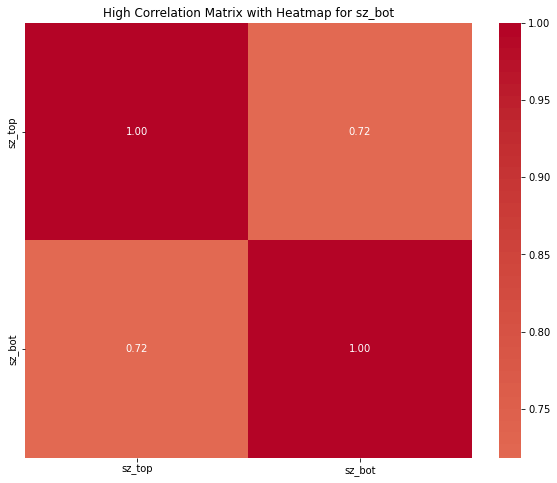

In [50]:
# Sample data loading (assuming 'df' is already loaded)
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select correlations related to 'sz_bot' and filter for high correlations
high_correlations = correlation_matrix['sz_bot'][correlation_matrix['sz_bot'].abs() > 0.6]

# Print the high correlation values
print("High Correlations with sz_bot:")
print(high_correlations)

# Create a new DataFrame for the heatmap that only includes features with high correlations
high_corr_features = high_correlations.index.tolist()
high_corr_matrix = df[high_corr_features].corr()

# Visualization using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('High Correlation Matrix with Heatmap for sz_bot')
plt.show()

Does this also suggest low interpretability for pitch type for sz_top?

In [51]:
import plotly.graph_objects as go

fig = go.Figure()
# Get all unique pitch types
pitch_types = df['pitch_type'].unique()

# Add overall data as the first trace
fig.add_trace(go.Box(y=df['sz_top'], name='Overall'))

# Add traces for each pitch type
for pitch in pitch_types:
    fig.add_trace(go.Box(y=df[df["pitch_type"] == pitch]['sz_top'], name=pitch))

# Update layout to show legend
fig.update_layout(
    title="sz_top by Pitch Type",
    yaxis_title="sz_top",
    showlegend=True
)

# Show the figure
fig.show()

# 3. Feature Engineering

### Dealing with Data Leaks

While these provide good overall information, the speed/curve variables contain information about the target variable which might are misleading - properties of the current pitch. This implicates non independence, likely create bias and multicollinearity when creating the model; breaking the indepedent assumption about X to y relationship

Features to average:
- Start_speed
- Spin rate
- Break_angle
- Break length

In [241]:
average_start_speed_pitcher = df.groupby("pitcher_id")['start_speed'].mean().reset_index()
average_break_angle_pitcher = df.groupby("pitcher_id")['break_angle'].mean().reset_index()
average_break_length_pitcher = df.groupby("pitcher_id")['break_length'].mean().reset_index()
average_spin_rate_pitcher = df.groupby("pitcher_id")['spin_rate'].mean().reset_index()


Histogram of the different pitcher measure distribution - We find a left skewed distribution

<AxesSubplot:ylabel='Count'>

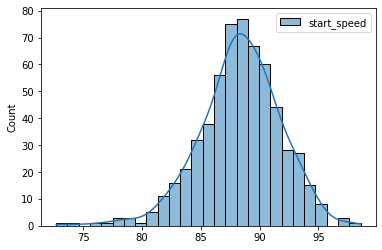

In [53]:
sns.histplot(data=average_start_speed_pitcher, kde=True)


The average break angle by player's distribution is left skewed and bimodal

<AxesSubplot:ylabel='Count'>

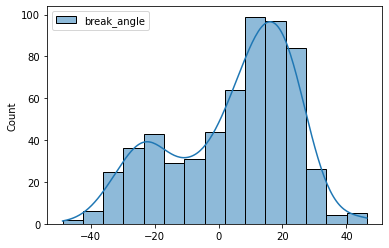

In [54]:
sns.histplot(data=average_break_angle_pitcher, kde=True)


The average break length across players has a sligltly right skewed distribution

<AxesSubplot:ylabel='Count'>

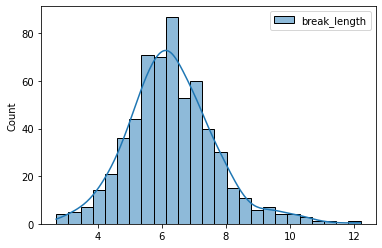

In [55]:
sns.histplot(data=average_break_length_pitcher, kde=True)


The spin rate is very midly left skewed

<AxesSubplot:ylabel='Count'>

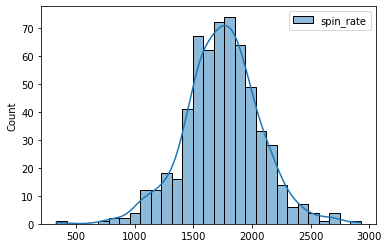

In [56]:
sns.histplot(data=average_spin_rate_pitcher, kde=True)


Merge them into a dataframe for better analysis

In [242]:
avg_pitcher = average_start_speed_pitcher.merge(average_break_angle_pitcher, on='pitcher_id').merge(average_break_length_pitcher, on='pitcher_id').merge(average_spin_rate_pitcher, on='pitcher_id')

avg_pitcher.head()

,pitcher_id,start_speed,break_angle,break_length,spin_rate
0,110683,90.679825,15.684211,5.867105,1693.275614
1,112020,90.659052,19.060776,6.248491,1686.162942
2,112526,90.509943,26.496591,5.389205,1989.627081
3,115629,90.932530,24.950602,5.310241,1950.611771
4,115817,81.845897,15.734650,7.519757,1496.707561


In [58]:
avg_pitcher.describe()

,start_speed,break_angle,break_length,spin_rate
count,595.000000,595.000000,595.000000,595.000000
mean,88.323724,4.656180,6.303443,1744.882788
std,3.452123,18.891244,1.362696,320.168358
min,72.675000,-48.780000,2.700000,331.239000
25%,86.448750,-8.957246,5.441857,1556.218388
50%,88.433333,9.742857,6.212500,1746.244000
75%,90.547436,18.950443,7.045394,1936.921104
max,98.600000,46.400000,12.200000,2923.741000


### K-Mean 

Clustering the results - k means to find clusters amongst pitcher averages

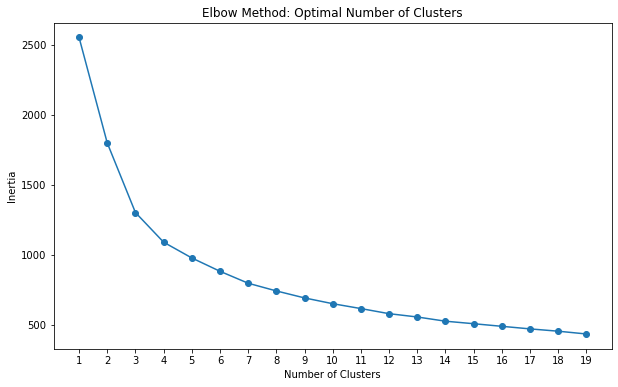

In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

avg_features = ['start_speed', 'break_angle', 'break_length', 'spin_rate']

# Prepare data for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(avg_pitcher[avg_features])

inertia = []
k_range = range(1, 20)  # trying 3 to 10 clusters of pitchers

for k in k_range:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow curve to find optimal number of clusters 
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()


### Cluster Feature

The Inertia seems to be decrease more slowly after 7 clusters - We avoid creating too many clusters to avoid overfitting, but enough to avoid underfitting; finding the best tradeoff with regards to inertia

Let's select 7:

In [244]:
# Pick optimal number of pitchers from plot above 
optimal_k = 7

# Cluster pitchers by their average values  
kmeans = KMeans(n_clusters = optimal_k)
avg_pitcher['cluster'] = kmeans.fit_predict(scaled_features)

Unique Clusters - 642; similar cluster 1 and cluster 2 (same proportion in %), same proportion between cluster 5 and 1 - if evenly split; 0 is 14%, Cluster 4 is 10%, Cluster 3 is only ;;;14% approx; more than that 

- x percent of players are in group more similar to each - this implicates x number profiles of pitchers: look at mean and median values of each variable by clusters - might find that cluster 3 has abnormally large / low based on 1 metric
- Take the cluster assignment as a feature

In [245]:
avg_pitcher.cluster.value_counts()

0    125
5    115
6    111
3    104
4     89
2     65
1     29
Name: cluster, dtype: int64

Finding unique cluster characteristic - Cluster 6 has characteristics which are strongly different from other clusters, having players with longer break length, slower start speed, and lower spin rate than other clusters. Inversely, players in cluster 0 will have faster pitches, higher break angles, lower break length and higher spin rate

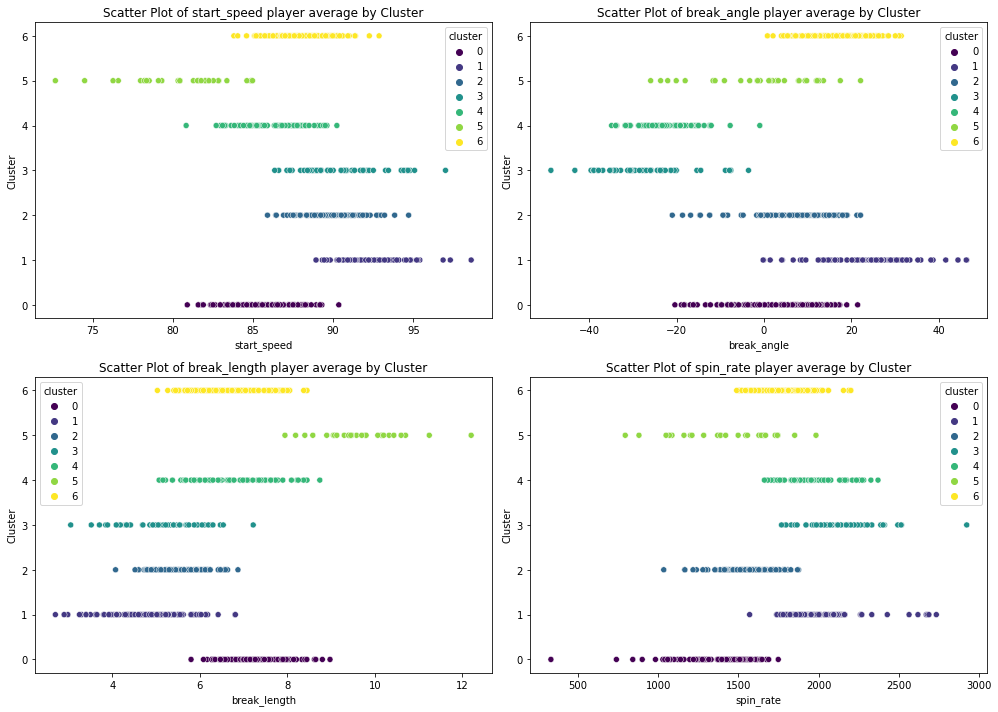

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))  # 2x2 subplot grid

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# List of metrics to plot against 'cluster'
metrics = ['start_speed', 'break_angle', 'break_length', 'spin_rate']

# Creating a scatter plot for each metric
for i, metric in enumerate(metrics):
    sns.scatterplot(data=avg_pitcher, x=metric, y='cluster', hue='cluster', ax=axs[i], palette='viridis')
    axs[i].set_title(f'Scatter Plot of {metric} player average by Cluster')
    axs[i].set_xlabel(metric)
    axs[i].set_ylabel('Cluster')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Boxplots comparing cluster median with all medians for player performances; 

In [63]:
import plotly.graph_objects as go
import pandas as pd

# Assuming avg_pitcher is your DataFrame and it's loaded with 'break_angle' and 'cluster' columns

# Box plot data for all entries
all_data = {
    'y': avg_pitcher['break_angle'],
    'type': 'box',
    'name': 'All Data',
    'boxpoints': 'outliers',  # Display outliers
    'marker': {'color': 'grey'},
    'opacity': 0.5
}

# Box plot data for cluster 1
cluster_data = {
    'y': avg_pitcher[avg_pitcher['cluster'] == 1]['break_angle'],
    'type': 'box',
    'name': 'Cluster 1',
    'boxpoints': 'outliers',  # Display outliers
    'marker': {'color': 'blue'}
}

# Adding both box plot data to a list
box_plots = [all_data, cluster_data]

# Create the figure with the box plots
fig = go.Figure(data=box_plots)

# Update the layout
fig.update_layout(
    title="Box Plots of Break Angle: All Data vs Cluster 1",
    xaxis_title="Data Category",
    yaxis_title="Break Angle",
    showlegend=True
)

# Adding median, Q1, and Q3 annotations for both box plots
# For all data
all_medians = avg_pitcher['break_angle'].quantile([0.25, 0.5, 0.75]).tolist()
fig.add_annotation(x=0, y=all_medians[1], text=f"Median: {all_medians[1]:.2f}", showarrow=True, arrowhead=1)


# For cluster 1
cluster_medians = avg_pitcher[avg_pitcher['cluster'] == 1]['break_angle'].quantile([0.25, 0.5, 0.75]).tolist()
fig.add_annotation(x=1, y=cluster_medians[1], text=f"Median: {cluster_medians[1]:.2f}", showarrow=True, arrowhead=1)


# Show the figure
fig.show()


### Features: Cluster-specific feature thresholds

We use these to create threshold to classify individual players according to their cluster standards; for instance, pitchers in cluster 1 have lower break angle. The aim is to refine our metric by comparing players with similar profiles

In [246]:

# Function to calculate and categorize metrics within each cluster
def categorize_metrics(df, metric):
    # Initialize a result Series to hold the categorized results, using object dtype to avoid categorical conflicts
    result = pd.Series(index=df.index, dtype="object")  # Using 'object' to avoid conflicts with Categorical dtype

    # Define the tier labels that will be used across all groups
    tier_labels = ['Very Low', 'Low', 'Middle', 'High', 'Very High']
    
    # Group by cluster and process each group individually
    for cluster, group in df.groupby('cluster'):
        # Calculate Q1, Q3, and IQR for the group
        Q1 = group[metric].quantile(0.25)
        Q3 = group[metric].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper fences for outliers
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR

        # Apply categorization based on the calculated fences
        bins = [-float('inf'), lower_fence, Q1, Q3, upper_fence, float('inf')]

        # Use pd.cut to categorize the metric and convert to string to avoid conflicts
        categories = pd.cut(group[metric], bins=bins, labels=tier_labels, include_lowest=True).astype(str)

        # Assign the categorized data back to the result Series
        result.loc[group.index] = categories

    return result

# Apply the function to multiple metrics in the DataFrame
avg_pitcher['start_speed_tier_cluster'] = categorize_metrics(avg_pitcher, 'start_speed')
avg_pitcher['break_length_tier_cluster'] = categorize_metrics(avg_pitcher, 'break_length')
avg_pitcher['spin_rate_tier_cluster'] = categorize_metrics(avg_pitcher, 'spin_rate')
avg_pitcher['break_angle_tier_cluster'] = categorize_metrics(avg_pitcher, 'break_angle')

# Print a sample of the DataFrame to verify the categories
#print(avg_pitcher[['start_speed', 'start_speed_tier', 'break_length', 'break_length_tier', 'spin_rate', 'spin_rate_tier', 'break_angle', 'break_angle_tier']].head())


Let's insert the cluster and feature tiers for pitcher in the dataframe

In [247]:
df2 = df.copy()

df2 = df2.merge(avg_pitcher, on='pitcher_id')

rename_columns = {
    'start_speed_y': 'start_speed_average_pitcher',
    'break_angle_y': 'break_angle_average_pitcher',
    'break_length_y': 'break_length_average_pitcher',
    'spin_rate_y': 'spin_rate_average_pitcher'
}

# Rename the columns in the DataFrame
df2 = df2.rename(columns=rename_columns)
df2

,uid,game_pk,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,...,on_3b,start_speed_average_pitcher,break_angle_average_pitcher,break_length_average_pitcher,spin_rate_average_pitcher,cluster,start_speed_tier_cluster,break_length_tier_cluster,spin_rate_tier_cluster,break_angle_tier_cluster
0,15539189,287508,144,117,3,0,25,3,62,0,...,NaN,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low
1,16964839,288115,140,117,6,1,39,2,90,0,...,NaN,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low
2,15704240,287583,141,117,3,0,25,4,34,1,...,NaN,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low
3,19606814,289240,115,117,4,1,34,1,56,0,...,NaN,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low
4,19262357,289100,143,117,3,1,18,3,38,0,...,NaN,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162768,16694561,288000,139,158,8,1,67,3,16,2,...,NaN,84.766667,15.766667,5.366667,1811.485000,0,Low,Low,Middle,Low
162769,16694566,288000,139,158,8,1,68,2,21,1,...,NaN,84.766667,15.766667,5.366667,1811.485000,0,Low,Low,Middle,Low
162770,19698319,289281,135,112,7,0,49,1,7,0,...,NaN,94.800000,36.550000,4.550000,2258.146000,5,High,Low,Very High,High
162771,19698297,289281,135,112,6,0,44,3,3,1,...,NaN,94.800000,36.550000,4.550000,2258.146000,5,High,Low,Very High,High


### Feature: Most Frequent Prior Pitches by pitcher

In [248]:
# Function to get the most frequent pitch type from all prior pitches (those with lower pitch_id) for each pitcher
def get_most_frequent_prior_pitch(row, df):
    current_pitch_id = row['pitch_id']
    # Filter the DataFrame for pitches with lower pitch_id than the current one, but only for the same pitcher
    prior_pitches = df[df['pitch_id'] < current_pitch_id]
    
    # Check if there are any prior pitches
    if prior_pitches.empty:
        return 'No prior pitch'  # Return a label for rows with no prior pitches
    else:
        # Calculate the most frequent pitch type in prior pitches
        return prior_pitches['pitch_type'].value_counts().idxmax()

# Apply the function within each pitcher group
def apply_to_group(group):
    # Apply the get_most_frequent_prior_pitch function to each row of the group
    group['most_frequent_prior_pitch'] = group.apply(lambda row: get_most_frequent_prior_pitch(row, group), axis=1)
    return group

# Group the DataFrame by 'pitcher_id' and apply the function to each group
df2_with_most_frequent = df2.groupby('pitcher_id').apply(apply_to_group)

# Reset the index after applying to groups
df2_with_most_frequent = df2_with_most_frequent.reset_index(drop=True)

In [250]:
df2_with_most_frequent = df2_with_most_frequent[df2_with_most_frequent['most_frequent_prior_pitch'] != 'No prior pitch']
df2_with_most_frequent

,uid,game_pk,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,...,start_speed_average_pitcher,break_angle_average_pitcher,break_length_average_pitcher,spin_rate_average_pitcher,cluster,start_speed_tier_cluster,break_length_tier_cluster,spin_rate_tier_cluster,break_angle_tier_cluster,most_frequent_prior_pitch
0,15539189,287508,144,117,3,0,25,3,62,0,...,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low,Fastball
1,16964839,288115,140,117,6,1,39,2,90,0,...,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low,Fastball
2,15704240,287583,141,117,3,0,25,4,34,1,...,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low,Fastball
3,19606814,289240,115,117,4,1,34,1,56,0,...,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low,Fastball
4,19262357,289100,143,117,3,1,18,3,38,0,...,86.394971,3.385201,6.285920,1464.237756,6,Middle,Low,Middle,Low,Fastball
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162764,19056374,289012,139,140,7,0,56,5,20,2,...,91.466667,16.233333,4.100000,2154.868000,5,Middle,Low,High,Middle,Fastball
162765,15584059,287531,145,140,8,0,65,2,13,1,...,81.450000,5.750000,8.600000,1093.476500,1,Middle,Middle,Low,Middle,Slider
162767,16694565,288000,139,158,8,1,68,1,20,0,...,84.766667,15.766667,5.366667,1811.485000,0,Low,Low,Middle,Low,Fastball
162769,16694566,288000,139,158,8,1,68,2,21,1,...,84.766667,15.766667,5.366667,1811.485000,0,Low,Low,Middle,Low,Slider


### Feature: Two plus players on base

Two players on a base at once might interfer with the pitcher's ability to pitch, or even yet involve a tendency towards a certain pitch type. We create a binary variable to see if 2 players on a base at the same time

In [251]:
# Function to create a binary variable for having exactly two IDs
def two_players(row):
    # Count the non-null values in the 'on_1b', 'on_2b', 'on_3b' columns
    count_non_null = sum(pd.notnull([row['on_1b'], row['on_2b'], row['on_3b']]))
    return 'Yes' if count_non_null >= 2 else 'No'

# Apply the function to each row and create a new column 'two_players'
df2_with_most_frequent['two_plus_players_base'] = df2_with_most_frequent.apply(two_players, axis=1)
# We remove them since our new features provides more interpretable information
df2_with_most_frequent = df2_with_most_frequent.drop(columns=['on_1b', 'on_2b', 'on_3b'])


# 4. Pre-Processing

### Feature Selection using Lasso with Cross Validation

We do a Lasso Cross-validation with optimal alpha value to see which features would need to be dropped out

In [512]:
df_new = df2_with_most_frequent.copy()

In [513]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression

In the EDA, we have identified columns which did not change much between pitch types. We remove them, as well as columns which have a strong relationship with them. As mentioned earlier, some variables, like start_speed, end_speed etc are only available after the pitch is thrown, and some are data leaks of the target variable. We remove all of the latter to only retain relevant variables

In [514]:
# Define columns to exclude based on various criteria
insignificant_columns = ['sz_bot', 'sz_top', 'vx0', 'vy0']
additional_exclusions = ['on_1b', 'on_2b', 'on_3b']
post_pitch_columns = ['pfx_z', 'px', 'pz', 'x0', 'z0', 'y0', 'vz0', 'ax', 'az', 'ay', 
                      'pitch_tfs_zulu', 'x', 'y', 'end_speed', 'final_balls', 
                      'final_strikes', 'final_outs', 'away_team_runs', 'home_team_runs', 
                      'nasty', 'spin_dir', 'type_confidence']
# Create exclusions for columns ending with '_x' or 'id'
pattern_exclusions = [col for col in df_new.columns if col.endswith('_x') or col.endswith('id')
or col.endswith('_y')]

object_columns = df_new.select_dtypes(include=['object', 'category']).columns.tolist()

# Combine all exclusions
excluded_columns = set(insignificant_columns + additional_exclusions + post_pitch_columns + pattern_exclusions
+ [col for col in object_columns if col != 'pitch_type'])
# Drop the excluded columns (all object or category columns except 'pitch_type')
filtered_df = df_new.drop(columns=excluded_columns, errors='ignore')

# Select only numerical columns (int and float) along with 'pitch_type'
filtered_df = filtered_df.select_dtypes(include=['int', 'float', 'object']).copy()

filtered_df = filtered_df.dropna(axis=1)
filtered_df

,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,pitch_type,start_speed_average_pitcher,break_angle_average_pitcher,break_length_average_pitcher,spin_rate_average_pitcher,cluster
0,3,0,25,3,62,0,2,1,1,Slider,86.394971,3.385201,6.285920,1464.237756,6
1,6,1,39,2,90,0,1,1,1,Cutter,86.394971,3.385201,6.285920,1464.237756,6
2,3,0,25,4,34,1,2,0,1,Fastball,86.394971,3.385201,6.285920,1464.237756,6
3,4,1,34,1,56,0,0,0,0,Slider,86.394971,3.385201,6.285920,1464.237756,6
4,3,1,18,3,38,0,2,0,2,Cutter,86.394971,3.385201,6.285920,1464.237756,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162764,7,0,56,5,20,2,2,2,2,Changeup,91.466667,16.233333,4.100000,2154.868000,5
162765,8,0,65,2,13,1,0,0,1,Sinker,81.450000,5.750000,8.600000,1093.476500,1
162767,8,1,68,1,20,0,0,0,2,Slider,84.766667,15.766667,5.366667,1811.485000,0
162769,8,1,68,2,21,1,0,0,2,Fastball,84.766667,15.766667,5.366667,1811.485000,0


In [515]:
# Select features (X) and the target variable (y) using the filtered columns
X = filtered_df.select_dtypes(include=['int', 'float'])
y = filtered_df['pitch_type']

In [516]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
# Split the data into training and testing sets

In [517]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded.argmax(axis=1), test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [518]:
# Initialize LassoCV
lasso_cv = LassoCV(cv=5, random_state=10)

# Use SelectFromModel with LassoCV
sel_ = SelectFromModel(lasso_cv)

# Fit the model
sel_.fit(X_train_scaled, y_train)

# Get the model's coefficients after selecting the best alpha
coef_ = sel_.estimator_.coef_

# Identify features that model hasn't eliminated; i.e., features with non-zero coefficients
non_zero_feats = X_train.columns[(coef_ != 0).ravel().tolist()]

# Display the features that were not removed
print("Features not removed (with non-zero coefficients):", non_zero_feats)



Features not removed (with non-zero coefficients): Index(['top', 'at_bat_num', 'pcount_pitcher', 'balls', 'strikes', 'fouls',
       'outs', 'start_speed_average_pitcher', 'break_angle_average_pitcher',
       'break_length_average_pitcher', 'spin_rate_average_pitcher', 'cluster'],
      dtype='object')


Checking collinearity between columns with non zero feats - We find moderate collinearity with most of our variables. Our feature engineered columns for pitcher average indicate strong collinearities

In [519]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a new dataframe with the non-zero features
X_non_zero_feats = X_train[non_zero_feats]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_non_zero_feats.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_non_zero_feats.values, i)
                          for i in range(len(X_non_zero_feats.columns))]

print(vif_data)


                         feature         VIF
0                            top    2.056609
1                     at_bat_num    3.811491
2                 pcount_pitcher    2.558915
3                          balls    2.039087
4                        strikes    3.314010
5                          fouls    2.068797
6                           outs    2.433969
7    start_speed_average_pitcher  188.136380
8    break_angle_average_pitcher    1.309905
9   break_length_average_pitcher   38.836994
10     spin_rate_average_pitcher   90.433734
11                       cluster    3.550978


We retain all of these columns:

In [644]:
# Make a copy of df2_with_most_frequent to avoid modifying the original dataframe
df_new = df2_with_most_frequent.copy()

# Define the list of non-numeric feature-engineered columns (specific to your case)
feature_engineered_columns = [
    'start_speed_average_pitcher', 'break_angle_average_pitcher', 'break_length_average_pitcher', 
    'spin_rate_average_pitcher', 'most_frequent_prior_pitch', 'two_plus_players_base',
    'start_speed_tier_cluster', 'break_length_tier_cluster', 'spin_rate_tier_cluster', 
    'break_angle_tier_cluster', 'cluster'
]

# Define the list of features to keep: non-zero features, non-numerical feature-engineered columns, and 'pitch_type'
features_to_keep = list(non_zero_feats) + feature_engineered_columns + ['pitch_type']

# Filter the dataframe to keep only the specified columns
df_new = df_new[features_to_keep]

# Display the updated dataframe
df_new.head()


,top,at_bat_num,pcount_pitcher,balls,strikes,fouls,outs,start_speed_average_pitcher,break_angle_average_pitcher,break_length_average_pitcher,...,break_length_average_pitcher,spin_rate_average_pitcher,most_frequent_prior_pitch,two_plus_players_base,start_speed_tier_cluster,break_length_tier_cluster,spin_rate_tier_cluster,break_angle_tier_cluster,cluster,pitch_type
0,0,25,62,0,2,1,1,86.394971,3.385201,6.28592,...,6.28592,1464.237756,Fastball,No,Middle,Low,Middle,Low,6,Slider
1,1,39,90,0,1,1,1,86.394971,3.385201,6.28592,...,6.28592,1464.237756,Fastball,No,Middle,Low,Middle,Low,6,Cutter
2,0,25,34,1,2,0,1,86.394971,3.385201,6.28592,...,6.28592,1464.237756,Fastball,No,Middle,Low,Middle,Low,6,Fastball
3,1,34,56,0,0,0,0,86.394971,3.385201,6.28592,...,6.28592,1464.237756,Fastball,No,Middle,Low,Middle,Low,6,Slider
4,1,18,38,0,2,0,2,86.394971,3.385201,6.28592,...,6.28592,1464.237756,Fastball,No,Middle,Low,Middle,Low,6,Cutter


### Class Imbalance Solution

Let's solve the class imbalance - we find add pitch types into groups with similar features: 

In [645]:
df_new['pitch_type'].value_counts()

Fastball       79280
Sinker         21790
Slider         20673
Changeup       18540
Cutter         10034
Curveball       8738
Splitter        2257
Knuckleball      574
Name: pitch_type, dtype: int64

In [658]:
# Define the mapping from specific pitch types to general categories
pitch_categories = {
    'Fastball': 'Fastballs',
    'Sinker': 'Fastballs',  # Depending on your categorization preference
    'Cutter': 'Fastballs',
    'Splitter': 'Fastballs',
    'Curveball': 'Breaking Balls',
    'Slider': 'Breaking Balls',
    'Screwball': 'Breaking Balls',
    'Changeup': 'Changeups',
}

# Map the specific pitch types to general categories
df_new['pitch_group'] = df_new['pitch_type'].map(pitch_categories)

df_model = df_new.copy()

df_model = df_model.drop(columns=["pitch_type"])

Train the model and predict either of the groups; create models trained under; separately train and test these models then test the all; downsample the data. Make these models and only downsample when training in each one of them.

Separate data into 4 groups; before train model with each of them separately; downsample each of them 

In [659]:
pitch_counts = df_model['pitch_group'].value_counts()

# Step 1: Remove classes with fewer than 3000 observations
filtered_pitch_types = pitch_counts[pitch_counts >= 18000].index
df_filtered = df_model[df_model['pitch_group'].isin(filtered_pitch_types)]

# Step 2: Downsample the majority classes to match the size of the smallest class
min_count = pitch_counts[pitch_counts >= 18000].min()

# Resample each class to have the same number of observations as the minimum class
df_balanced = df_filtered.groupby('pitch_group').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

df_model = df_balanced
# Display the new pitch type distribution
print(df_balanced['pitch_group'].value_counts())


Breaking Balls    18540
Changeups         18540
Fastballs         18540
Name: pitch_group, dtype: int64


Transforming Data:

In [660]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Identify all int and float columns
numerical_columns = df_model.select_dtypes(include=['int', 'float']).columns.tolist()

# Fit and transform these numerical columns
df_model[numerical_columns] = scaler.fit_transform(df_model[numerical_columns])


### Explanatory and Target Variables

Separating Explanatory and Target Variables

In [661]:
df_new2 = df_model.copy()
df_new2 = df_new2.dropna()

In [662]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Automatically select all columns except 'pitch_type'
feature_columns = df_new2.columns.difference(['pitch_group'])

# Select features (X) and the target variable (y) using the filtered columns
X = df_new2[feature_columns]
y = df_new2['pitch_group']


### Encoding

In [663]:
X_categorical = X.select_dtypes(include=['object', 'category'])
X_numerical = X.select_dtypes(include=['int', 'float'])
dummies = pd.get_dummies(X_categorical)
merged = pd.concat([X_numerical,dummies],axis=1)
X = merged
X

,at_bat_num,balls,break_angle_average_pitcher,break_angle_average_pitcher,break_length_average_pitcher,break_length_average_pitcher,cluster,cluster,fouls,outs,...,spin_rate_tier_cluster_Middle,spin_rate_tier_cluster_Very High,spin_rate_tier_cluster_Very Low,start_speed_tier_cluster_High,start_speed_tier_cluster_Low,start_speed_tier_cluster_Middle,start_speed_tier_cluster_Very High,start_speed_tier_cluster_Very Low,two_plus_players_base_No,two_plus_players_base_Yes
0,0.188680,0.394734,0.671242,0.671242,-0.068073,-0.068073,-1.444651,-1.444651,-0.533348,1.250905,...,1,0,0,1,0,0,0,0,0,1
1,2.016481,0.394734,0.020269,0.020269,0.937322,0.937322,1.317423,1.317423,-0.533348,1.250905,...,0,0,0,0,0,1,0,0,1,0
2,0.691325,0.394734,0.744505,0.744505,1.354652,1.354652,1.317423,1.317423,-0.533348,0.016337,...,1,0,0,1,0,0,0,0,1,0
3,-0.268271,-0.938141,-1.434306,-1.434306,-0.464068,-0.464068,-0.523960,-0.523960,-0.533348,0.016337,...,0,0,0,0,0,1,0,0,0,1
4,1.331055,0.394734,1.188750,1.188750,-0.946386,-0.946386,0.857077,0.857077,-0.533348,1.250905,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55615,-1.045086,-0.938141,0.816999,0.816999,-0.112870,-0.112870,-0.063614,-0.063614,-0.533348,-1.218232,...,0,0,0,0,0,1,0,0,1,0
55616,-0.176880,1.727609,0.003896,0.003896,-0.738873,-0.738873,-0.063614,-0.063614,2.971681,1.250905,...,1,0,0,0,1,0,0,0,1,0
55617,0.188680,-0.938141,0.723609,0.723609,0.852993,0.852993,1.317423,1.317423,-0.533348,-1.218232,...,1,0,0,1,0,0,0,0,1,0
55618,1.422445,-0.938141,0.840277,0.840277,1.883567,1.883567,-1.444651,-1.444651,-0.533348,0.016337,...,1,0,0,1,0,0,0,0,1,0


In [664]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode the target variable
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))


### Test-Train split

In [665]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded.argmax(axis=1), test_size=0.2, random_state=42)


# 5. Logistic Regression Model

In [666]:

# Create and fit the logistic regression model (assuming a multinomial case since it's categorical)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

Model underfitting

In [667]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.50      0.47      0.48      3730
           1       0.47      0.52      0.50      3670
           2       0.46      0.45      0.45      3724

    accuracy                           0.48     11124
   macro avg       0.48      0.48      0.48     11124
weighted avg       0.48      0.48      0.48     11124



Model accuracy metric

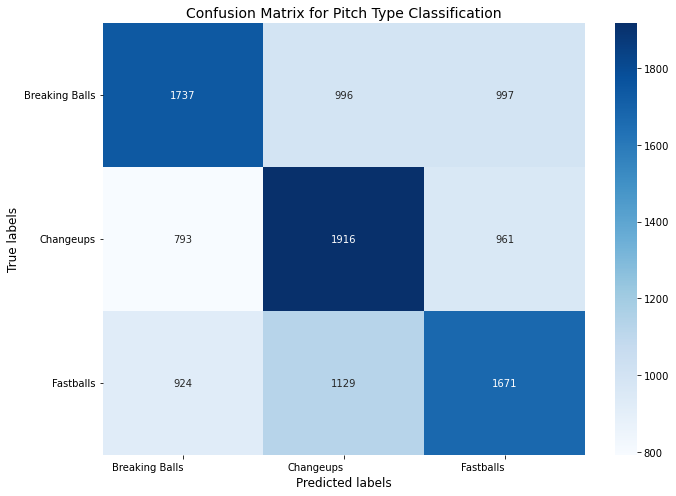

In [668]:
from sklearn.metrics import confusion_matrix
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique pitch types to label the confusion matrix
pitch_types = encoder.categories_[0]  # This will give the pitch type names from the encoder used earlier

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=pitch_types, columns=pitch_types)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')  # fmt='g' ensures integer formatting

# Add labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix for Pitch Type Classification', fontsize=14)

# Set tick labels for x and y axis using the pitch type names
ax.xaxis.set_ticklabels(pitch_types, rotation=0, ha="right", fontsize=10)  # Rotate for better readability
ax.yaxis.set_ticklabels(pitch_types, rotation=0, fontsize=10)  # Keep vertical

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


# 6. Random Forest Model and Feature Importance

We use Random Forest to see if there is additional accuracy

In [669]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier with additional parameters
rf_classifier = RandomForestClassifier(
    n_estimators=1000,         # Number of trees
    max_depth=40,             # Maximum depth of the tree
    min_samples_split=8,      # Minimum samples to split a node
    min_samples_leaf=4,       # Minimum samples at a leaf node
    max_features="sqrt",      # Number of features to consider for best split
    bootstrap=True,           # Use bootstrap samples
    criterion="gini",         # Use Gini impurity to split
    random_state=42
)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Generate a classification report
print(f"Accuracy: {accuracy:.4f}")
print(classification_rep)


Accuracy: 0.5528
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      3730
           1       0.55      0.65      0.60      3670
           2       0.54      0.44      0.49      3724

    accuracy                           0.55     11124
   macro avg       0.55      0.55      0.55     11124
weighted avg       0.55      0.55      0.55     11124



Add feature importance bars together

                       Prefix  Importance
10                     pcount    0.128895
0                      at_bat    0.123693
13        start_speed_average    0.110393
2         break_angle_average    0.104930
11          spin_rate_average    0.096756
4        break_length_average    0.087347
15                    strikes    0.056496
9                        outs    0.044742
1                       balls    0.044278
8   most_frequent_prior_pitch    0.033350
16                        top    0.030569
7                       fouls    0.021248
14   start_speed_tier_cluster    0.020217
17      two_plus_players_base    0.020134
5   break_length_tier_cluster    0.019601
3    break_angle_tier_cluster    0.019528
6                     cluster    0.019392
12     spin_rate_tier_cluster    0.018430


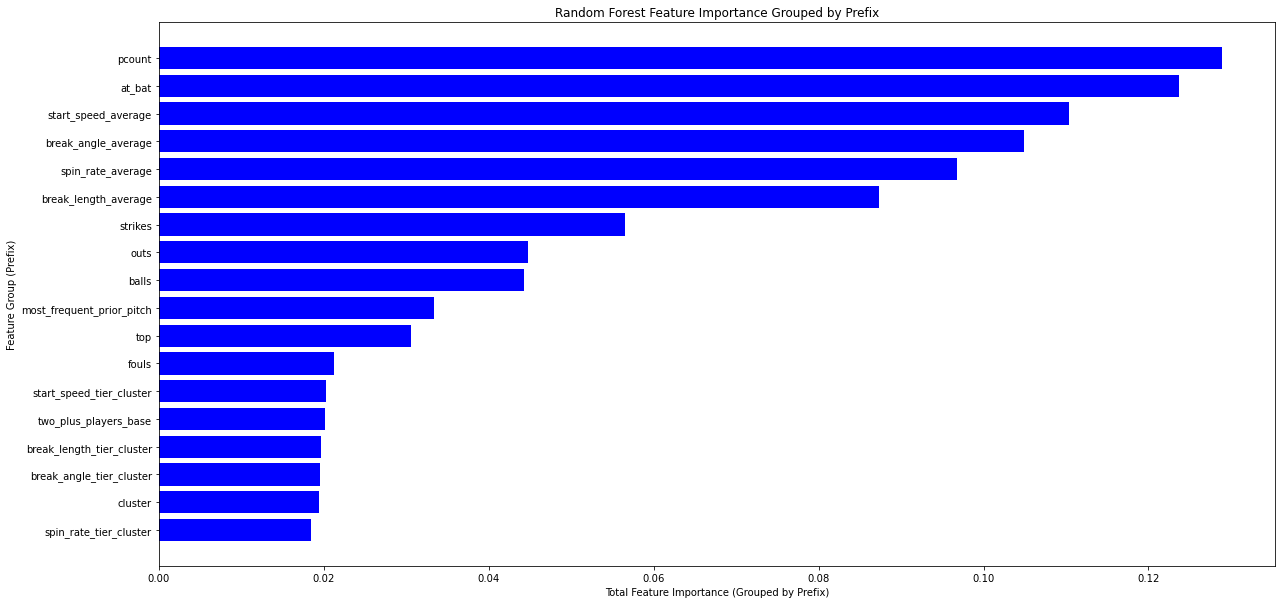

In [670]:
# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,  # Column names of your features
    'Importance': rf_classifier.feature_importances_
})

# Extract prefix (before the last '_') and group the importance values by this prefix
feature_importances_df['Prefix'] = feature_importances_df['Feature'].apply(lambda x: '_'.join(x.split('_')[:-1]) if '_' in x else x)

# Group by the prefix and sum the importances
grouped_importances_df = feature_importances_df.groupby('Prefix')['Importance'].sum().reset_index()

# Sort the grouped importances by descending order
grouped_importances_df = grouped_importances_df.sort_values(by='Importance', ascending=False)

# Display the grouped feature importance
print(grouped_importances_df)

# Plot the grouped feature importances
plt.figure(figsize=(20, 10))
plt.barh(grouped_importances_df['Prefix'], grouped_importances_df['Importance'], color='blue')
plt.xlabel('Total Feature Importance (Grouped by Prefix)')
plt.ylabel('Feature Group (Prefix)')
plt.title('Random Forest Feature Importance Grouped by Prefix')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


# 7. Additional Model Experimentation

We experiment by going through each pitch group, and predicting the pitch type: For instance, the Fastball pitch group contains Sinker, Cutter, Fastball, and Spitter. We create a subset with the Fastball group and predict the pitch types

Model for Fastballs:
Accuracy: 0.770764119601329
              precision    recall  f1-score   support

      Cutter       0.73      0.75      0.74       466
    Fastball       0.75      0.69      0.72       431
      Sinker       0.79      0.75      0.77       466
    Splitter       0.81      0.89      0.85       443

    accuracy                           0.77      1806
   macro avg       0.77      0.77      0.77      1806
weighted avg       0.77      0.77      0.77      1806



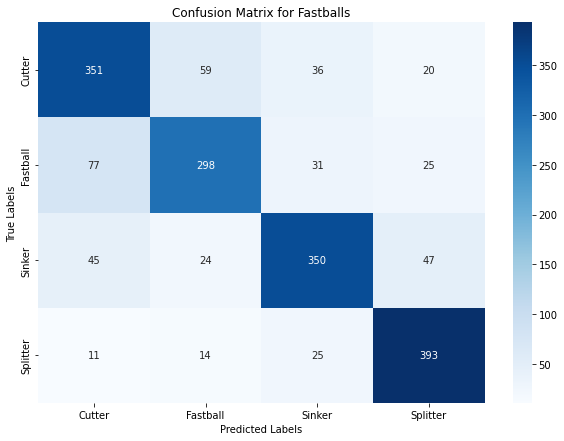

Model for Breaking Balls:
Accuracy: 0.8483981693363845
              precision    recall  f1-score   support

   Curveball       0.83      0.87      0.85      1740
      Slider       0.86      0.83      0.85      1756

    accuracy                           0.85      3496
   macro avg       0.85      0.85      0.85      3496
weighted avg       0.85      0.85      0.85      3496



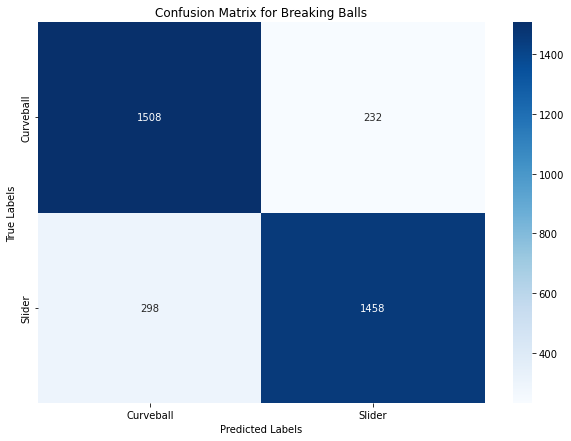

Model for Changeups:
Accuracy: 1.0
              precision    recall  f1-score   support

    Changeup       1.00      1.00      1.00      3708

    accuracy                           1.00      3708
   macro avg       1.00      1.00      1.00      3708
weighted avg       1.00      1.00      1.00      3708



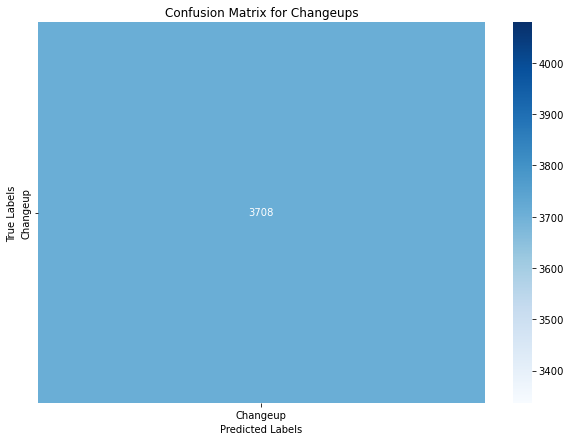

In [672]:
def train_evaluate(data, features, target, group_name):
    data = data.copy()
    data = data.drop(columns=['pitch_group'])
    pitch_counts = data[target].value_counts()
    filtered_pitch_types = pitch_counts[pitch_counts >= 1000].index
    df_filtered = data[data[target].isin(filtered_pitch_types)]
    # Step 2: Downsample the majority classes to match the size of the smallest class
    min_count = pitch_counts[filtered_pitch_types].min()
    # Resample each class to have the same number of observations as the minimum class
    df_model = df_filtered.groupby(target).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
    
    scaler = StandardScaler()
    numerical_columns = df_model.select_dtypes(include=['int', 'float']).columns.tolist()
    df_model[numerical_columns] = scaler.fit_transform(df_model[numerical_columns])
    
    X = df_model[features]
    y = df_model[target]
    X_categorical = X.select_dtypes(include=['object', 'category'])
    X_numerical = X.select_dtypes(include=['int', 'float'])
    dummies = pd.get_dummies(X_categorical)
    merged = pd.concat([X_numerical, dummies], axis=1)
    X = merged

    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    y_labels = encoder.categories_[0]  # Capture the encoded pitch types

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Model training
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train.argmax(axis=1))
    
    # Prediction and evaluation
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred)}")
    print(classification_report(y_test.argmax(axis=1), y_pred, target_names=y_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
    plt.title(f'Confusion Matrix for {group_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Define features (excluding the target and any non-feature columns)
features = df_new.columns.difference(['pitch_type', 'pitch_group', 'other_non_feature_columns'])

# Separate datasets
fastballs = df_new[df_new['pitch_group'] == 'Fastballs']
breaking_balls = df_new[df_new['pitch_group'] == 'Breaking Balls']
changeups = df_new[df_new['pitch_group'] == 'Changeups']

# Train and evaluate for each pitch type category
print("Model for Fastballs:")
train_evaluate(fastballs, features, 'pitch_type', 'Fastballs')

print("Model for Breaking Balls:")
train_evaluate(breaking_balls, features, 'pitch_type', 'Breaking Balls')

print("Model for Changeups:")
train_evaluate(changeups, features, 'pitch_type', 'Changeups')